# ECON408: Assignment 4

Jesse Perla, UBC


## Nolan / 92071885


### Instructions

-   Edit the above cell to include your name and student number.
-   Submit just this `ipynb` to Canvas. Do not rename, it associates
    your student number with the submission automatically.

In [6]:
using Distributions, Plots, LaTeXStrings, LinearAlgebra, Statistics, Random, QuantEcon, NLsolve

## Question 1

Take the example in [Simple Example with iid
Income](https://jlperla.github.io/ECON408/lectures/permanent_income.html#/iid-income-lss)
where the stochastic process for income $y_t$ follows

$$
y_t = \mu + \sigma w_t \sim N(\mu, \sigma^2)
$$

Under these assumptions, with quadratic utility and if $\beta R = 1$ the
optimal policy is

$$
\mathbb{E}_t\{c_{t+1}\} = c_t
$$

Which we can use to derive for this income process if $F_0 = y_0 = 0$.

$$
c_t = (1-\beta)\left(\mathbb{E}_t\left[\sum_{j=0}^\infty \beta^j y_{t+j}\right] + F_t\right) =  \mu + (1 - \beta) \sigma \sum_{j=1}^t w_j
$$

And finally

$$
F_t  = \sigma \sum_{j=1}^{t-1} w_j
$$

### Part (a)

Code to simulate this consumption process for $t = 1, \ldots T$ is given
below.

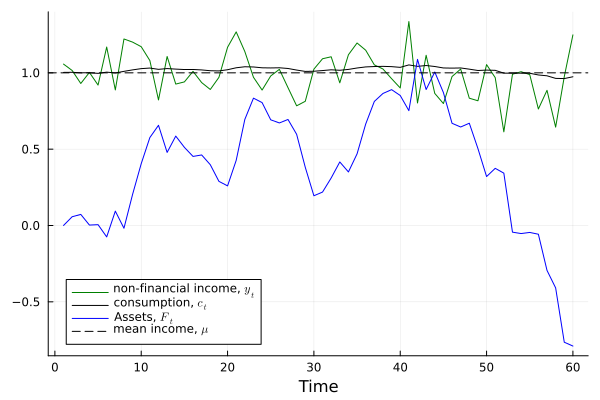

In [37]:
function simulate_iid_income(p, T; w = randn(T))
    w_sum = cumsum(w) #(w_1, w_1 + w_2, w_1 + w_2 + w_3, ... sum_{j=1}^T w_j))    
    c = p.mu .+ (1 - p.beta) * p.sigma  * w_sum # (c_1, c_2, ... c_T)
    y = p.mu .+ p.sigma * w # (y_1, y_2, ... y_T)
    F = [0.0; p.sigma * w_sum[1:end-1]] #(F_1, F_2, ... F_T)
    return (;w, F, c, y)
end

p = (;beta= 1.0 / (1.0 + 0.05), mu = 1.0, sigma = 0.15)
T = 60
res = simulate_iid_income(p, T)

plot(1:T, res.y, color = :green, label = L"non-financial income, $y_t$", xlabel="Time")
plot!(res.c, color = :black, label = L"consumption, $c_t$")
plot!(res.F, color = :blue, label = L"Assets, $F_t$")
hline!([p.mu], color = :black, linestyle = :dash, label = L"mean income, $\mu$")

Using this code, plot call the above where instead of randomly drawing
each $w \sim N(0,1)$ draw it from a distribution $w \sim N(0.5, 1)$ and
plot the results

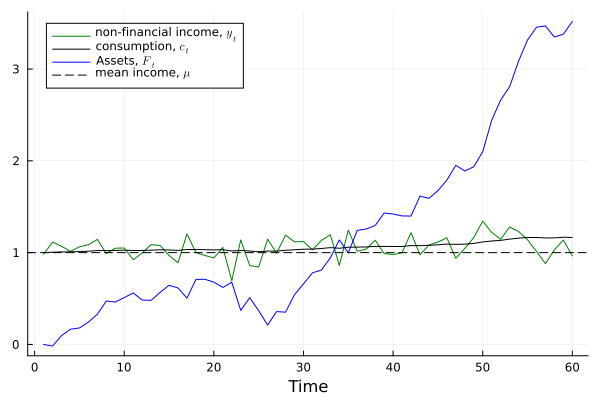

In [9]:
# edit your code here
d = Normal(0.5,1)
function simulate_iid_income(p, T; w = randn(T) .+0.5)
    w_sum = cumsum(w) #(w_1, w_1 + w_2, w_1 + w_2 + w_3, ... sum_{j=1}^T w_j))    
    c = p.mu .+ (1 - p.beta) * p.sigma  * w_sum # (c_1, c_2, ... c_T)
    y = p.mu .+ p.sigma * w # (y_1, y_2, ... y_T)
    F = [0.0; p.sigma * w_sum[1:end-1]] #(F_1, F_2, ... F_T)
    return (;w, F, c, y)
end

p = (;beta= 1.0 / (1.0 + 0.05), mu = 1.0, sigma = 0.15)
T = 60
res = simulate_iid_income(p, T)

plot(1:T, res.y, color = :green, label = L"non-financial income, $y_t$", xlabel="Time")
plot!(res.c, color = :black, label = L"consumption, $c_t$")
plot!(res.F, color = :blue, label = L"Assets, $F_t$")
hline!([p.mu], color = :black, linestyle = :dash, label = L"mean income, $\mu$")

### Part (b)

Interpret the result of the previous graph with the standard one with
well-specified results from the perspective of consumption smoothing and
forecasting of income. In what ways is the behavior in the second case
not optimal and why?

The second case is not optimal. With the modified distribution, there is now a upawrd bias in income shocks rather than the orginal consumption behaviour that oscilliates around the mean income The upward shock is expected to be 0.5, and financial assets are here expected to grow with time. We can also interepret financial assets as accumulated unanticipated income shock which was expected to be zero in the basecase and now has a upward bias to be 0.5 each period. This is likely not an optimal model for financial assets.

With consumption smoothing in the new model, there is now a persistent overestimation of future income, which might encourage consumption pattern that adjust upward more aggresivelly in response and diverge from the ideal of consumption smoothing. In the context of consumption smoothing, there is not an imbalance with consumption smoothing as individuals now have a upward bias in their forecasted.income.

## Question 2

Continuing with income process defined in Part 1, rather than manually
implementing this process, [use the LSS
formulation](https://jlperla.github.io/ECON408/lectures/permanent_income.html#/stacked-lss-for-iid-income)

$$
\begin{aligned}
\begin{bmatrix} w_{t+1} \\ 1 \end{bmatrix} &= \begin{bmatrix} 0 & 0 \\ 0 & 1 \end{bmatrix} \begin{bmatrix} w_t \\ 1 \end{bmatrix}+ \begin{bmatrix} 1 \\ 0 \end{bmatrix} w_{t+1}\\
y_t &= \begin{bmatrix} \sigma & \mu \end{bmatrix}\begin{bmatrix} w_t \\ 1 \end{bmatrix}
\end{aligned}
$$ From this, we can stack, etc. following [our
notes](https://jlperla.github.io/ECON408/lectures/permanent_income.html#/stacked-lss)

The simulation from the code was

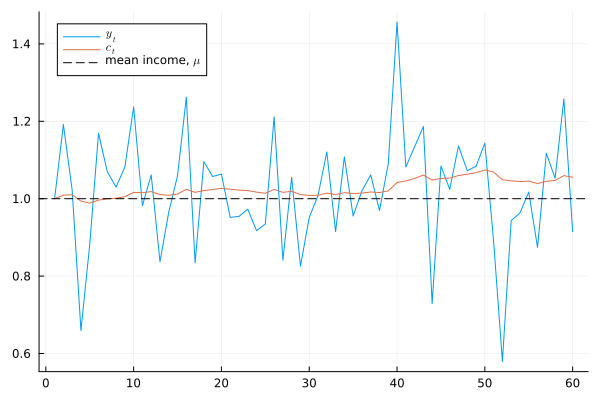

In [38]:
A = [0 0; 0 1]
G = [p.sigma p.mu]
C = [1; 0]
H = G*inv(I-p.beta*A)
A_tilde = [A zeros(2,1); H*(I-A) 1]
C_tilde = [C; 0]
G_tilde = [G 0; (1-p.beta)*H 1-p.beta]
x_tilde_0 = [0.0, 1, 0.0] #[w_0, 1, F_0]
lss_pi = LSS(A_tilde, C_tilde, G_tilde;
              mu_0 = x_tilde_0)
x, y = simulate(lss_pi, T)
plot(1:T, y[1,:];label=L"y_t", size=(600,400))
plot!(1:T, y[2,:], label=L"c_t")
hline!([p.mu], color=:black, linestyle=:dash,
       label = L"mean income, $\mu$")

### Part (a)

Try calculating the stationary distribution by modifying the code below
or trying with your existing code.

In [43]:
# modify here from previous results
mu_x, mu_y, sigma_x, sigma_y = stationary_distributions(lss_pi)

ErrorException: Convergence failed after 201 iterations

In [42]:
eigenvalues = eigvals(A_tilde)

3-element Vector{Float64}:
 0.0
 1.0
 1.0

Explain why it does or does not converge below

Eigenvalue of A_tilde is (0 1 1) - the eigenvalues is not less than 1. The process does not converge and all reponses within the system does not diminish overtime. 

### Part (b)

Consider a variation on the state space model above where instead of the
state being above which puts the $\sigma$ in the

$$
C \equiv
\begin{bmatrix}
    \sigma \\
    0
\end{bmatrix}
$$

rather than in the $G$. Complete that state space model, and change the
implementation below (copied from the above for simplicity)

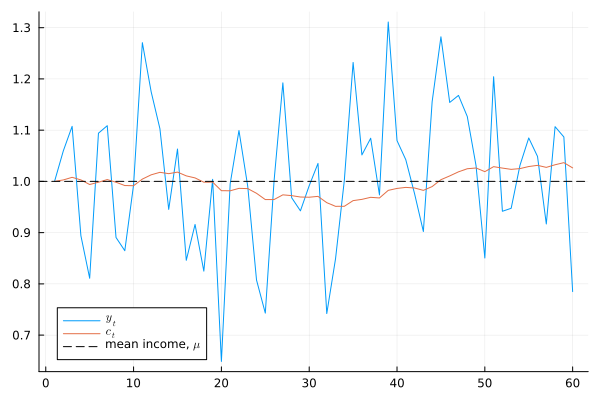

In [21]:
# Modify here
A = [0 0; 0 1]
G = [1 p.mu]
C = [p.sigma; 0] # replace with $C = [\sigma; 0]$ and fix the rest of the LSS/etc.
H = G*inv(I-p.beta*A)
A_tilde = [A zeros(2,1); H*(I-A) 1]
C_tilde = [C; 0]
G_tilde = [G 0; (1-p.beta)*H 1-p.beta]
x_tilde_0 = [0.0, 1, 0.0] #[w_0, 1, F_0]
lss_pi = LSS(A_tilde, C_tilde, G_tilde;
              mu_0 = x_tilde_0)
x, y = simulate(lss_pi, T)
plot(1:T, y[1,:];label=L"y_t", size=(600,400))
plot!(1:T, y[2,:], label=L"c_t")
hline!([p.mu], color=:black, linestyle=:dash,
       label = L"mean income, $\mu$")

## Question 3

Recall the [Lake
Model](https://jlperla.github.io/ECON408/lectures/markov_chains_applications.html#/lake-model-of-unemployment-and-employment)
of unemployment and employment. Summarizing, while in the labor market,
workers are employed or unemployed, where

-   $\lambda$, the job finding rate for currently unemployed workers and
    $\alpha$ is the dismissal rate for currently employed workers
-   $b$ is the entry rate into the labor force, $d$ is the exit rate,
    and $g = b - d$. New entrance into the labor force is assumed to be
    unemployed.
-   $E_t$ is the total number of employed workers, $U_t$ is the total
    number of unemployed workers and $N_t = E_t + U_t$ is the total
    number of workers in the labor force.
-   The employment and unemployment rate are $e_t \equiv E_t / N_t$ and
    $u_t \equiv U_t / N_t$ respectively.
-   Define $X_t \equiv \left(\begin{matrix}U_t\\E_t\end{matrix}\right)$
    and $x_t \equiv \left(\begin{matrix}u_t\\e_t\end{matrix}\right)$.

With this, we constructed the equation for the evolution of the state
vector $X_{t+1}$ as

$$
X_{t+1} = \underbrace{\begin{bmatrix}
    (1-d)(1-\lambda) + b & (1-d)\alpha + b  \\
    (1-d)\lambda & (1-d)(1-\alpha)
\end{bmatrix}}_{\equiv A} X_t
$$

And

$$
x_{t+1} = \underbrace{\frac{1}{1 + g} A}_{\equiv \hat{A}} x_t
$$

Finally, the Markov chain for an agent (before exit) is

$$
P = \begin{bmatrix}
            1 - \lambda & \lambda \\
            \alpha & 1 - \alpha
        \end{bmatrix}
$$

In the lectures we had code for general simulations using a model and
collection of parameters

In [7]:
# Reusable functions, do not modify
function iterate_map(f, x0, T)
    x = zeros(length(x0), T + 1)
    x[:, 1] = x0
    for t in 2:(T + 1)
        x[:, t] = f(x[:, t - 1])
    end
    return x
end
function LakeModel(; lambda = 0.283, alpha = 0.013, b = 0.0124, d = 0.00822)
    g = b - d
    A = [(1 - lambda) * (1 - d)+b (1 - d) * alpha+b
         (1 - d)*lambda (1 - d)*(1 - alpha)]
    P = [(1 - lambda) lambda
         alpha 1 - alpha]
    A_hat = A ./ (1 + g)
    x_0 = ones(size(A_hat, 1)) / size(A_hat, 1)
    sol = fixedpoint(x -> A_hat * x, x_0)
    converged(sol) || error("Failed to converge in $(sol.iterations) iter")    
    x_bar =sol.zero
    return (; lambda, alpha, b, d, A, A_hat, x_bar, P)
end

LakeModel (generic function with 1 method)

Using the above code, we can solve for the dynamics of the stocks with

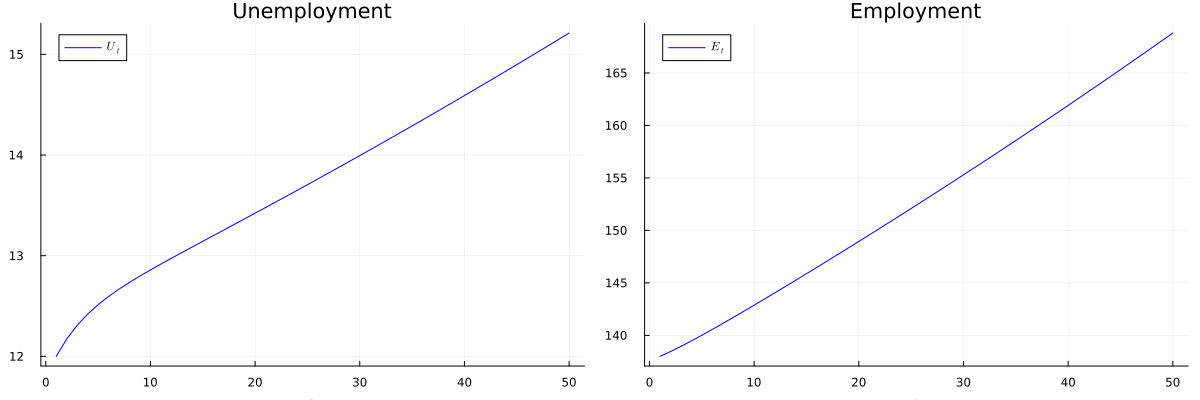

In [12]:
lm = LakeModel()
N_0 = 150
e_0 = 0.92
u_0 = 1 - e_0
T = 50
U_0 = u_0 * N_0
E_0 = e_0 * N_0
X_0 = [U_0; E_0]
X_path = iterate_map(X -> lm.A * X, X_0, T - 1)
x1 = X_path[1, :]
x2 = X_path[2, :]
plt_unemp = plot(1:T, X_path[1, :]; color = :blue,
                 label = L"U_t", xlabel="t", title = "Unemployment")
plt_emp = plot(1:T, X_path[2, :]; color = :blue,
               label = L"E_t", xlabel="t", title = "Employment")
plot(plt_unemp, plt_emp, layout = (1, 2), size = (1200, 400))

Similarly, we can plot the evolution of the employment and unemployment
rates after finding the steady state:

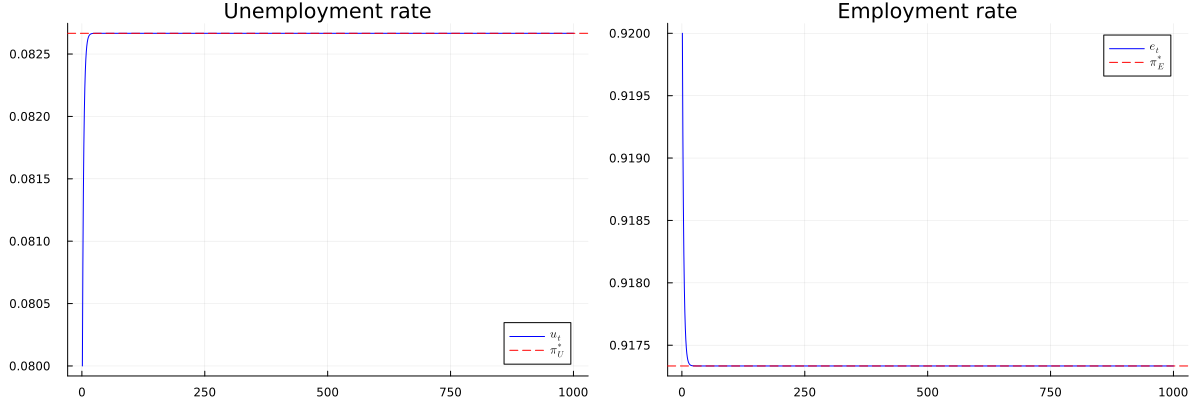

In [19]:
u_bar, e_bar = lm.x_bar
x_0 = [u_0; e_0]
x_path = iterate_map(x -> lm.A_hat * x, x_0, T - 1)
plt_unemp = plot(1:T, x_path[1, :];title = "Unemployment rate", 
                 color = :blue, label = L"u_t")
hline!(plt_unemp, [u_bar], color = :red, linestyle = :dash, label = L"\pi^{*}_U")
plt_emp = plot(1:T, x_path[2, :]; title = "Employment rate", color = :blue, label = L"e_t")
hline!(plt_emp, [e_bar], color = :red, linestyle = :dash,label = L"\pi^{*}_E")
plot(plt_unemp, plt_emp, layout = (1, 2), size = (1200, 400))

### Part (a)

Repeating the above code, plot the dynamics of the unemployment and
employment rates for the model with `b = d = 0`, but keeping all of the
other parameters as given.

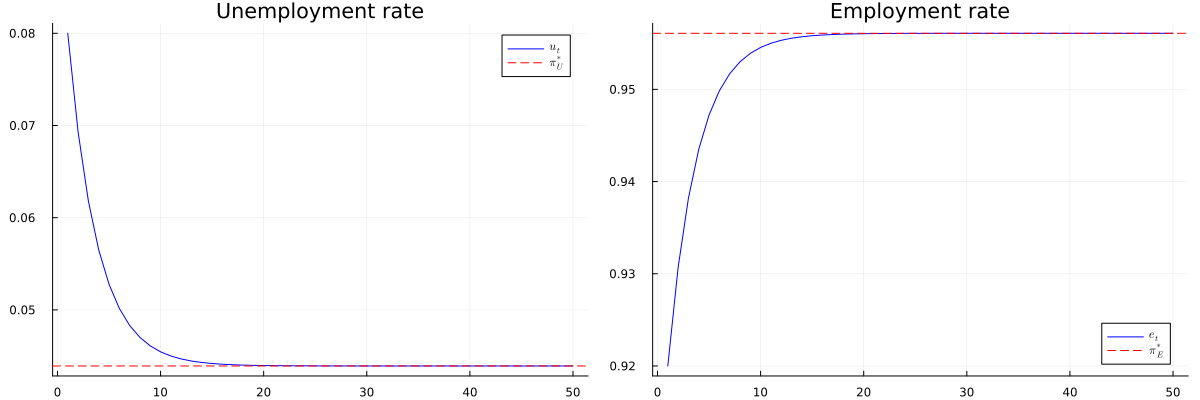

In [22]:
# edit your code here
lm = LakeModel(; lambda = 0.283, alpha = 0.013, b = 0, d = 0)
N_0 = 150
e_0 = 0.92
u_0 = 1 - e_0
T = 50
U_0 = u_0 * N_0
E_0 = e_0 * N_0
X_0 = [U_0; E_0]
X_path = iterate_map(X -> lm.A * X, X_0, T - 1)
x1 = X_path[1, :]
x2 = X_path[2, :]
plt_unemp = plot(1:T, X_path[1, :]; color = :blue,
                 label = L"U_t", xlabel="t", title = "Unemployment")
plt_emp = plot(1:T, X_path[2, :]; color = :blue,
               label = L"E_t", xlabel="t", title = "Employment")
plot(plt_unemp, plt_emp, layout = (1, 2), size = (1200, 400))

u_bar, e_bar = lm.x_bar
x_0 = [u_0; e_0]
x_path = iterate_map(x -> lm.A_hat * x, x_0, T - 1)
plt_unemp = plot(1:T, x_path[1, :];title = "Unemployment rate", 
                 color = :blue, label = L"u_t")
hline!(plt_unemp, [u_bar], color = :red, linestyle = :dash, label = L"\pi^{*}_U")
plt_emp = plot(1:T, x_path[2, :]; title = "Employment rate", color = :blue, label = L"e_t")
hline!(plt_emp, [e_bar], color = :red, linestyle = :dash,label = L"\pi^{*}_E")
plot(plt_unemp, plt_emp, layout = (1, 2), size = (1200, 400))


Interpret why this is different from the previous case (talk about
transition dynamics as well as the steady-states)

In term of transition dynamics, with B and D set to 0, the labour force is constant in this economy as there are no entrants and exits, and what we see is purely the internal movement between employment and unemployment governed by job finding rate and dismissal rate. 

In terms of steady state, without new entrants and exits, adjustments to reach the steady state depend entirely on the rates of finding jobs and losing jobs. These processes is shown to be slower than the combined adjustments that include labor force entries and exits, leading to a slower approach to the steady state.

### Part (b)

The Markov chain for an individual starting in the employment state can
be simulated using the markov chain already calculated in our previous
code,

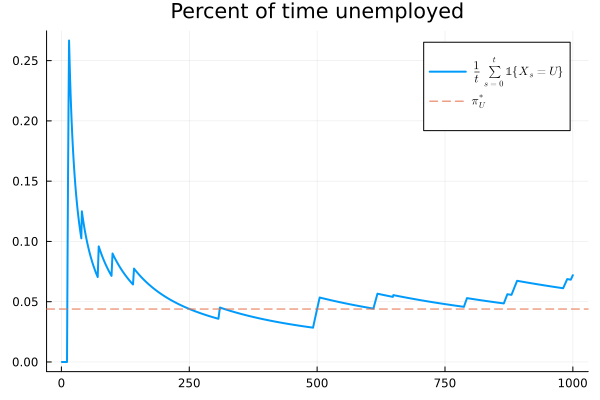

In [25]:
lm = LakeModel()
T = 1000
mc = MarkovChain(lm.P, [0; 1])     # 0=unemployed, 1=employed
s_path = simulate(mc, T; init = 2)
u_bar, e_bar = stationary_distributions(mc)[1]
# Note mapping in MarkovChain
s_bar_e = cumsum(s_path) ./ (1:T)
s_bar_u = 1 .- s_bar_e
s_bars = [s_bar_u s_bar_e]
plot(title = "Percent of time unemployed",
 1:T, s_bars[:, 1], lw = 2,
 label=L"\frac{1}{t}\sum_{s=0}^t \mathbb{1}\{X_s = U\}",
 legend=:topright, size=(600, 400))
hline!([u_bar], linestyle = :dash,
       label = L"\pi^{*}_U")

Modify this same graph, but now start the agent in unemployed state,

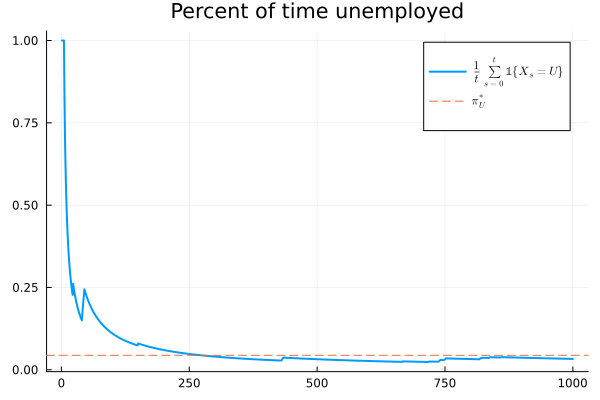

In [26]:
# edit your code here
s_path = simulate(mc, T; init = 1)
u_bar, e_bar = stationary_distributions(mc)[1]
# Note mapping in MarkovChain
s_bar_e = cumsum(s_path) ./ (1:T)
s_bar_u = 1 .- s_bar_e
s_bars = [s_bar_u s_bar_e]
plot(title = "Percent of time unemployed",
 1:T, s_bars[:, 1], lw = 2,
 label=L"\frac{1}{t}\sum_{s=0}^t \mathbb{1}\{X_s = U\}",
 legend=:topright, size=(600, 400))
hline!([u_bar], linestyle = :dash,
       label = L"\pi^{*}_U")


In [33]:
mc = [0.7170000000000001 0.283; 0.013 0.987]
eigvals(mc)

2-element Vector{Float64}:
 0.7040000000000001
 1.0

Interpret these graphs. In particular: (1) why are the different; (2)
why does it converge; and (3) why does it converge to the same point?



1. We should expect them to be different as the intial state is different. In the basecase we can see we start wit percent of time unemployed = 0 while here we start with 100%.
2. The Markov chain has a unique steady-state (or stationary) distribution that reflects the long-term probabilities of being in each state (employed or unemployed), given the transition probabilities. Hence, the markov chain converge. We can also see that the eigvals consist of 1 and other values less than 1, which is a condition that shows the markov chain converges. 
2. We know that Markov Chains have ergodocity. This property ensures that the long-term behavior of the chain is determined by its transition probabilities rather than its initial condition. Hence, the effect of initial condition is eventually washed out, and the convergence level is independant of the inital condition.

## Question 4

Take the [McCall search model with
separation](https://julia.quantecon.org/dynamic_programming/mccall_model_with_separation.html)
we discussed in class.

That implemented the following Bellman equation:

$$
V(w) = u(w) + \beta [(1-\alpha)V(w) + \alpha U ]
$$

and

$$
U = u(c) +
  \beta (1 - \gamma) U +
  \beta \gamma \sum_i \max \left\{ U, V(w_i) \right\} p_i
$$

where $\gamma$ is the probability of a job offer while unemployed,
$\alpha$ is the probability of exogenous separation, $u$ is the utility
function, and $w_i$ is the wage offer with probability $p_i$.

The code which solves for this Bellman Equation is


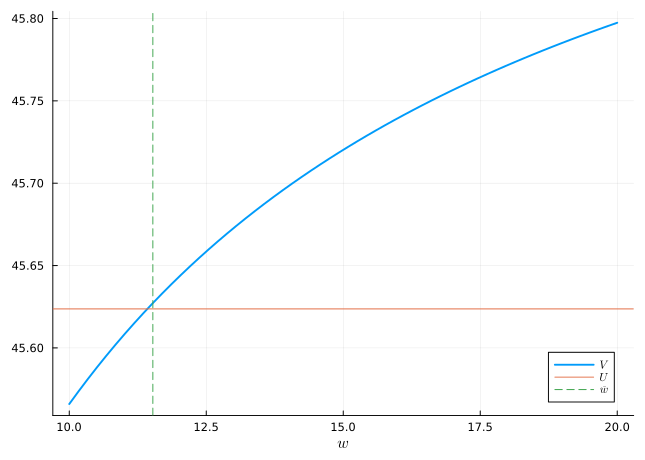

In [18]:
# model constructor
function mccall_model(;
    alpha = 0.2,
    beta = 0.98, # discount rate
    gamma = 0.7,
    c = 6.0, # unemployment compensation
    sigma = 2.0,
    w = range(10, 20, length = 60), # wage values
    dist = BetaBinomial(59, 600, 400)) # distribution over wage values
    return (; alpha, beta, sigma, c, gamma, w, dist, p = pdf.(dist, 0:length(w)-1))
end


function solve_mccall_model(mcm; U_iv = 1.0, V_iv = ones(length(mcm.w)), tol = 1e-5,
                            iter = 2_000)
    (; alpha, beta, sigma, c, gamma, w, sigma, p) = mcm
    u(c) = (c^(1 - sigma) - 1) / (1 - sigma)
    u_w = u.(w)
    u_c = u.(c)

    # Bellman operator T. Fixed point is x* s.t. T(x*) = x*
    function T(x)
        V = x[1:end-1]
        U = x[end]
        # V_p = u_w + beta * ((1 - alpha) * V .+ alpha * U), or expanding out
        V_p = [ u_w[i] + beta * ((1 - alpha) * V[i] + alpha * U) for i in 1:length(w)]
        U_p = u_c + beta * (1 - gamma) * U + beta * gamma * sum(max(U, V[i]) * p[i] for i in 1:length(w))
        return [V_p; U_p]
    end

    # value function iteration
    x_iv = [V_iv; U_iv] # initial x val
    xstar = fixedpoint(T, x_iv, iterations = iter, xtol = tol, m = 0).zero
    V = xstar[1:end-1]
    U = xstar[end]

    # compute the reservation wage
    wbarindex = searchsortedfirst(V .- U, 0.0)
    if wbarindex >= length(w) # if this is true, you never want to accept
        w_bar = Inf
    else
        w_bar = w[wbarindex] # otherwise, return the number
    end

    # return a NamedTuple, so we can select values by name
    return (;V, U, w_bar)
end

mcm = mccall_model()
sol = solve_mccall_model(mcm)

plot(mcm.w, sol.V, lw = 2, label = L"V", xlabel=L"w")
hline!(mcm.w, [sol.U], label=L"U")
vline!([sol.w_bar]; linestyle = :dash, label = L"\bar{w}")

Take the above equation, and consider a variation where there is
on-the-job searching for better jobs. With probability $\delta$ the
worker gets a job offer while employed

$$
V(w) = u(w) + \beta [(1-\alpha-\delta)V(w) + \alpha U + \delta \sum_i \max \left\{ V(w), V(w_i) \right\} p_i ]
$$

Note that the $\max$ is taken over the current wage and the arrival with
the same

$$
U = u(c) +
  \beta (1 - \gamma) U +
  \beta \gamma \sum_i \max \left\{ U, V(w_i) \right\} p_i
$$

Modify the code above to implement this new Bellman equation. Hint:
after adding the new constant, you will probably only need to change the
`u_w + beta * ((1 - alpha) * V .+ alpha * U)` function to include the
new term.

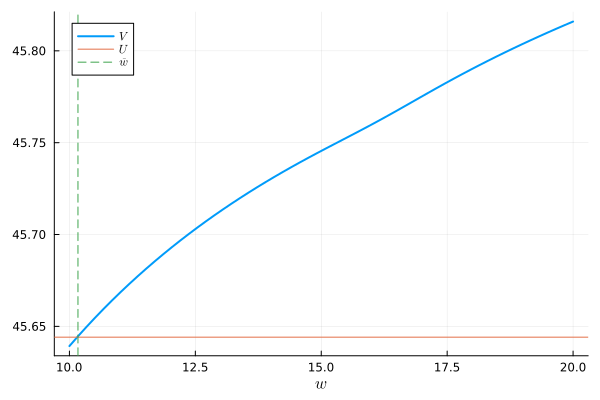

In [45]:
# edit your code here.  Hint: add parameter and look at the T operator
# model constructor
function new_mccall_model(;
    alpha = 0.2,
    beta = 0.98,
    gamma = 0.7,
    delta = 0.1, # NOTE NEW PARAMETER ADDED FOR YOU
    c = 6.0,
    sigma = 2.0,
    w = range(10, 20, length = 60),
    dist = BetaBinomial(59, 600, 400))
    return (; alpha, beta, sigma, delta, c, gamma, w, dist, p = pdf.(dist, 0:length(w)-1))
end


function new_solve_mccall_model(mcm; U_iv = 1.0, V_iv = ones(length(mcm.w)), tol = 1e-5,
                            iter = 2_000)
    (; alpha, beta, sigma, delta, c, gamma, w, p) = mcm
    u(c) = (c^(1 - sigma) - 1) / (1 - sigma)
    u_w = u.(w)
    u_c = u.(c)


# Bellman operator T. Fixed point is x* s.t. T(x*) = x*
    function T(x)
        V = x[1:end-1]
        U = x[end]
        V_p = [u_w[i] + beta * ((1 - alpha - delta) * V[i] + alpha * U + delta * sum(max(V[i], V[j]) * p[j] for j in 1:length(w))) for i in 1:length(w)]
        U_p = u_c + beta * (1 - gamma) * U + beta * gamma * sum(max(U, V[i]) * p[i] for i in 1:length(w))
        return [V_p; U_p]
    end

    # value function iteration
    x_iv = [V_iv; U_iv] # initial x val
    xstar = fixedpoint(T, x_iv, iterations = iter, xtol = tol, m = 0).zero
    V = xstar[1:end-1]
    U = xstar[end]

    # compute the reservation wage
    wbarindex = searchsortedfirst(V .- U, 0.0)
    if wbarindex >= length(w) # if this is true, you never want to accept
        w_bar = Inf
    else
        w_bar = w[wbarindex] # otherwise, return the number
    end

    # return a NamedTuple, so we can select values by name
    return (;V, U, w_bar)
end

mcm = new_mccall_model()
sol = new_solve_mccall_model(mcm)

plot(mcm.w, sol.V, lw = 2, label = L"V", xlabel=L"w")
hline!(mcm.w, [sol.U], label=L"U")
vline!([sol.w_bar]; linestyle = :dash, label = L"\bar{w}")